# Multidim Kernels

* goal is to find a kernel function which allows separate slopes in the low rho_0 vs high rho_0 area (separate slopes for both rho_0, gamma parameters)
* is this possible?

In [151]:
# utils section for plotting 2d kernels
import numpy as np, matplotlib.pyplot as plt

relu = lambda x : max([0.0, x])
unit_step = lambda x : 1.0 * (x > 0.0)

def smooth_relu(x, alpha):
    return np.log(1.0 + np.exp(alpha * x)) / alpha

def smooth_abs(x, alpha):
    return np.log(np.exp(-alpha * x) + np.exp(alpha * x)) / alpha

def smooth_unit_step(x, alpha):
    # not symmetric and breaks kernel functions
    return 1.0 / (1.0 + np.exp(-alpha * x))

def smooth_unit_step2(x, alpha):
    # hopefully better numerical stability for kernel functions (since sym about xx' < 0 and xx' > 0)
    return 0.5 * (1.0 + np.tanh(alpha * x))

def plot_2d_kernel(kernel_func, nsamples=1, nx=10, ny=10, sigma_n=0.0, plot_cov=False, sym=False):
    x_vec = np.linspace(-2.0, 2.0, nx)
    y_vec = np.linspace(-2.0, 2.0, ny)

    fig, ax = plt.subplots(2, nsamples//2, subplot_kw={"projection": "3d"})
    X, Y = np.meshgrid(x_vec, y_vec)
    N = nx * ny
    X_plot = np.zeros((N, 2))
    for i in range(nx):
        for j in range(ny):
            n = ny * i + j
            X_plot[n, 0] = x_vec[i]
            X_plot[n, 1] = y_vec[j]

    cov = np.array(
        [[kernel_func(X_plot[i, :], X_plot[j, :]) for i in range(N)] for j in range(N)]
    )
    cov += sigma_n**2 * np.eye(N)

    if sym:
        cov = cov + cov.T

    # random samples
    mean = np.zeros((N,))
    samples = np.random.multivariate_normal(mean, cov, nsamples)
    for i in range(nsamples):
        cY_arr = samples[i]
        X1 = X_plot[:, 0].reshape((nx, ny))
        X2 = X_plot[:, 1].reshape((nx, ny))
        Ym = cY_arr.reshape((nx, ny))
        # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax[i // 2, i % 2].plot_surface(X1, X2, Ym)
    plt.show()

    # plot covariance matrix
    if plot_cov:
        plt.figure("cov")
        plt.imshow(np.log(cov + 1e-8))
        plt.show()

    return cov

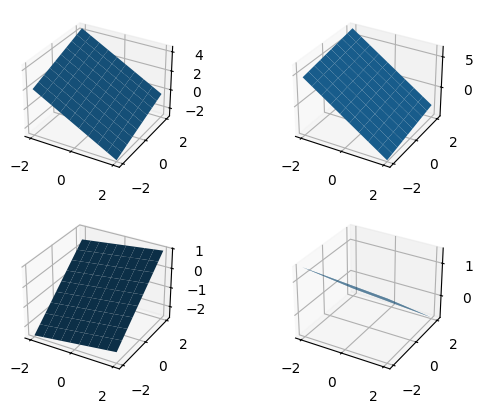

array([[ 8.3       ,  7.41111111,  6.52222222, ..., -5.92222222,
        -6.81111111, -7.7       ],
       [ 7.41111111,  6.71975309,  6.02839506, ..., -5.42839506,
        -6.11975309, -6.81111111],
       [ 6.52222222,  6.02839506,  5.5345679 , ..., -4.9345679 ,
        -5.42839506, -5.92222222],
       ...,
       [-5.92222222, -5.42839506, -4.9345679 , ...,  5.5345679 ,
         6.02839506,  6.52222222],
       [-6.81111111, -6.11975309, -5.42839506, ...,  6.02839506,
         6.71975309,  7.41111111],
       [-7.7       , -6.81111111, -5.92222222, ...,  6.52222222,
         7.41111111,  8.3       ]])

In [152]:
# 2D orthogonal linear kernels
def orthog_lin_kernel(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    return 0.3 + x * xp + y * yp

plot_2d_kernel(orthog_lin_kernel, nsamples=4)

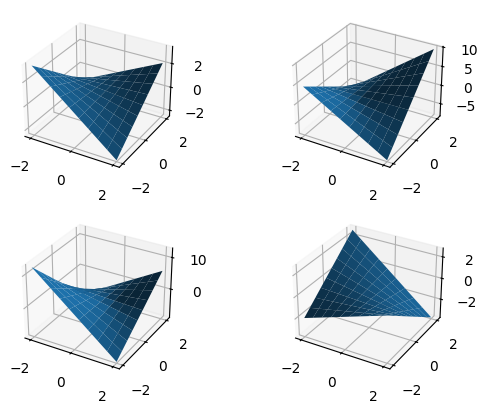

array([[40.3       , 32.3       , 24.3       , ..., 11.85555556,
        18.07777778, 24.3       ],
       [32.3       , 26.07777778, 19.85555556, ...,  8.39876543,
        13.2382716 , 18.07777778],
       [24.3       , 19.85555556, 15.41111111, ...,  4.94197531,
         8.39876543, 11.85555556],
       ...,
       [11.85555556,  8.39876543,  4.94197531, ..., 15.41111111,
        19.85555556, 24.3       ],
       [18.07777778, 13.2382716 ,  8.39876543, ..., 19.85555556,
        26.07777778, 32.3       ],
       [24.3       , 18.07777778, 11.85555556, ..., 24.3       ,
        32.3       , 40.3       ]])

In [153]:
# 2D quadratic bilinear linear kernels
#   I thought before that this is still a linear kernel, but it's not
#   y slope changes with x, has an x * y basis func term (nonlinear)
def quadratic_bilinear_kernel(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    return 0.3 + x * xp + y * yp + 2.0 * x * xp * y * yp

plot_2d_kernel(quadratic_bilinear_kernel, nsamples=4)

/tmp/ipykernel_245853/3052958101.py:45: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, nsamples)


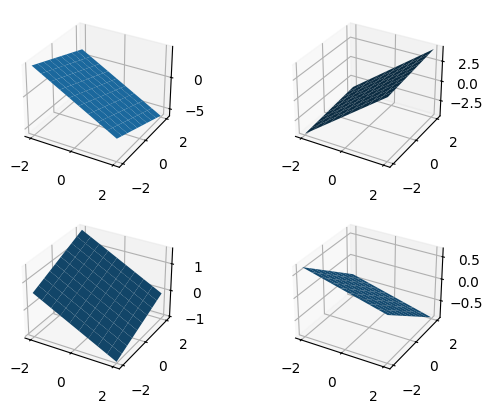

array([[ 24.3       ,  21.63333333,  18.96666667, ..., -18.36666667,
        -21.03333333, -23.7       ],
       [ 21.63333333,  19.16419753,  16.69506173, ..., -16.09506173,
        -18.56419753, -21.03333333],
       [ 18.96666667,  16.69506173,  14.42345679, ..., -13.82345679,
        -16.09506173, -18.36666667],
       ...,
       [-18.36666667, -16.09506173, -13.82345679, ...,  14.42345679,
         16.69506173,  18.96666667],
       [-21.03333333, -18.56419753, -16.09506173, ...,  16.69506173,
         19.16419753,  21.63333333],
       [-23.7       , -21.03333333, -18.36666667, ...,  18.96666667,
         21.63333333,  24.3       ]])

In [154]:
# full bilinear kernel (no nonlinearity)
#    slopes in x and y should still be constant
def full_bilinear_kernel(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    return 0.3 + x * xp + y * yp + 2.0 * x * yp + 2.0 * y * xp

plot_2d_kernel(full_bilinear_kernel, nsamples=4)

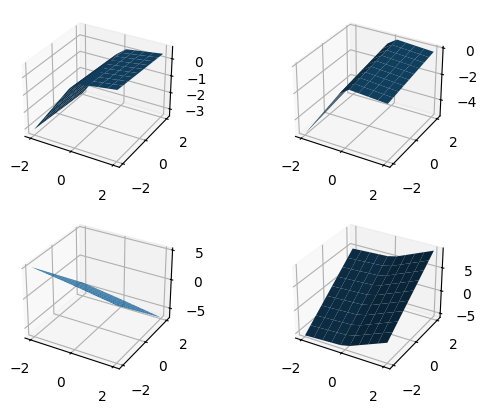

array([[12.3       , 10.52222222,  8.74444444, ..., -4.14444444,
        -5.92222222, -7.7       ],
       [10.52222222,  9.13950617,  7.75679012, ..., -3.15679012,
        -4.53950617, -5.92222222],
       [ 8.74444444,  7.75679012,  6.7691358 , ..., -2.1691358 ,
        -3.15679012, -4.14444444],
       ...,
       [-4.14444444, -3.15679012, -2.1691358 , ...,  6.7691358 ,
         7.75679012,  8.74444444],
       [-5.92222222, -4.53950617, -3.15679012, ...,  7.75679012,
         9.13950617, 10.52222222],
       [-7.7       , -5.92222222, -4.14444444, ...,  8.74444444,
        10.52222222, 12.3       ]])

In [155]:
# 2D gen absolute value kernel v1
    # general abs value in x (diff slopes x- and x+)
    # same slope in y at x- and x+ regions
def gen_absval_add(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    return 0.3 + relu(x * xp) + 2.0 * y * yp

plot_2d_kernel(gen_absval_add, nsamples=4) 

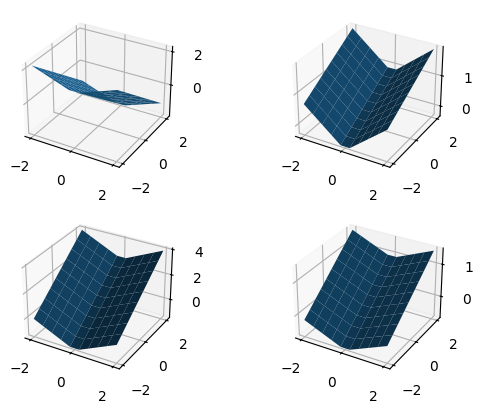

array([[12.3       , 10.52222222,  8.74444444, ..., -0.14444444,
        -1.92222222, -3.7       ],
       [10.52222222,  9.13950617,  7.75679012, ...,  0.84320988,
        -0.53950617, -1.92222222],
       [ 8.74444444,  7.75679012,  6.7691358 , ...,  1.8308642 ,
         0.84320988, -0.14444444],
       ...,
       [-0.14444444,  0.84320988,  1.8308642 , ...,  6.7691358 ,
         7.75679012,  8.74444444],
       [-1.92222222, -0.53950617,  0.84320988, ...,  7.75679012,
         9.13950617, 10.52222222],
       [-3.7       , -1.92222222, -0.14444444, ...,  8.74444444,
        10.52222222, 12.3       ]])

In [156]:
# 2D sym absolute value kernel v2
    # abs value in x
    # same slope in y at x- and x+ regions
def sym_absval_add(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    return 0.3 + np.abs(x * xp) + 2.0 * y * yp

plot_2d_kernel(sym_absval_add, nsamples=4) 

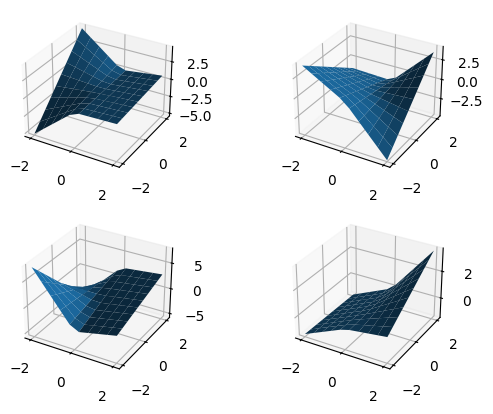

array([[18.49      , 14.66777778, 10.84555556, ..., -0.57666667,
        -0.84333333, -1.11      ],
       [14.66777778, 11.69493827,  8.72209877, ..., -0.42851852,
        -0.63592593, -0.84333333],
       [10.84555556,  8.72209877,  6.59864198, ..., -0.28037037,
        -0.42851852, -0.57666667],
       ...,
       [-0.57666667, -0.42851852, -0.28037037, ...,  6.59864198,
         8.72209877, 10.84555556],
       [-0.84333333, -0.63592593, -0.42851852, ...,  8.72209877,
        11.69493827, 14.66777778],
       [-1.11      , -0.84333333, -0.57666667, ..., 10.84555556,
        14.66777778, 18.49      ]])

In [157]:
# 2D absval kernel with multiplication
    # abs value in x
    # mult by y kernel so 
    # changes slopes, not what I want (but what I did in paper)
# this explains the bizarre shape in my axial buckling load
# surrogate model with gamma, rho_0 plot
def absval_mult(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    return (0.3 + relu(x * xp)) * (0.3 + y * yp)

plot_2d_kernel(absval_mult, nsamples=4) 

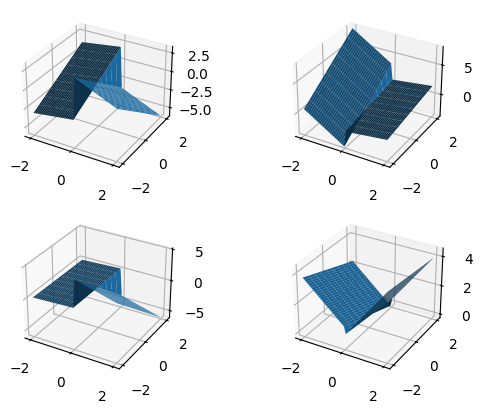

array([[12.3       , 10.52222222,  8.74444444, ...,  0.3       ,
         0.3       ,  0.3       ],
       [10.52222222,  9.13950617,  7.75679012, ...,  0.3       ,
         0.3       ,  0.3       ],
       [ 8.74444444,  7.75679012,  6.7691358 , ...,  0.3       ,
         0.3       ,  0.3       ],
       ...,
       [ 0.3       ,  0.3       ,  0.3       , ...,  6.7691358 ,
         7.75679012,  8.74444444],
       [ 0.3       ,  0.3       ,  0.3       , ...,  7.75679012,
         9.13950617, 10.52222222],
       [ 0.3       ,  0.3       ,  0.3       , ...,  8.74444444,
        10.52222222, 12.3       ]])

In [158]:
# 2D absval kernel with proper decoupling
    # general abs value in x
    # different slope in y at x- and x+ regions
# ends up being huge discontinuities here..
def absval_decoupled(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    return 0.3 + (x * xp + 2.0 * y * yp) * unit_step(x * xp)

plot_2d_kernel(absval_decoupled, nsamples=4, nx=50, ny=10) 

/tmp/ipykernel_245853/3052958101.py:45: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, nsamples)


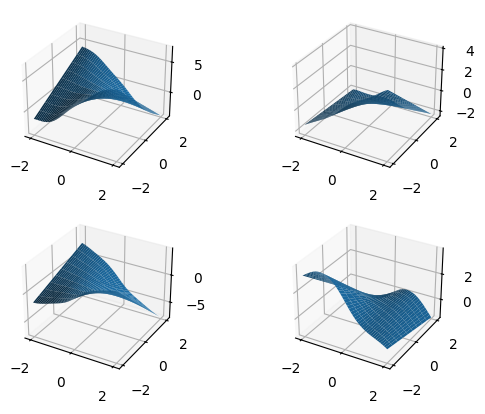

/tmp/ipykernel_245853/3052958101.py:58: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(cov + 1e-8))


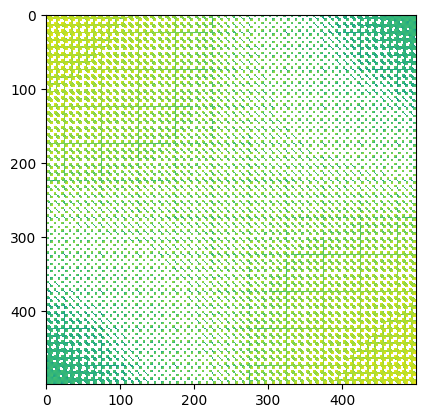

array([[12.08416549, 10.33836319,  8.59256089, ...,  0.14811645,
         0.11614096,  0.08416548],
       [10.33836319,  8.98051697,  7.62267073, ...,  0.16588061,
         0.14101079,  0.11614096],
       [ 8.59256089,  7.62267073,  6.65278058, ...,  0.18364477,
         0.16588061,  0.14811645],
       ...,
       [ 0.14811645,  0.16588061,  0.18364477, ...,  6.65278058,
         7.62267073,  8.59256089],
       [ 0.11614096,  0.14101079,  0.16588061, ...,  7.62267073,
         8.98051697, 10.33836319],
       [ 0.08416548,  0.11614096,  0.14811645, ...,  8.59256089,
        10.33836319, 12.08416549]])

In [159]:
# now smooth out the transition some, so no longer discontinuous
def absval_smooth_decoupled(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    return 0.3 + (x * xp + 2.0 * y * yp) * smooth_unit_step(x * xp, alpha=1.0)
# numerical stability issues with the first smooth unit step approx, tried second version below

plot_2d_kernel(absval_smooth_decoupled, nsamples=4, nx=50, ny=10, 
               sigma_n=1e-4, plot_cov=True) 

/tmp/ipykernel_245853/3052958101.py:45: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, nsamples)


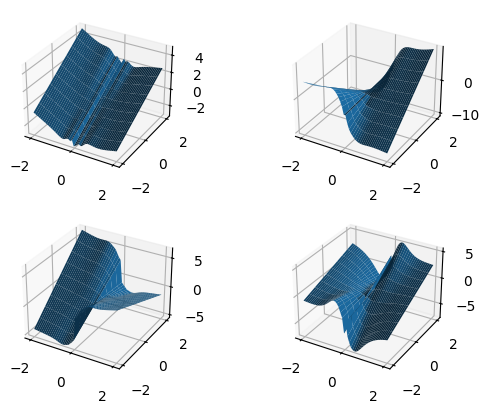

/tmp/ipykernel_245853/3052958101.py:58: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(cov + 1e-8))


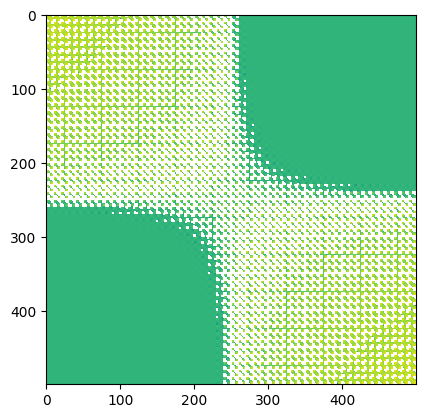

eigval=array([ 1.62962963e+03+0.00000000e+00j,  1.53219396e+03+0.00000000e+00j,
        9.37851331e+02+0.00000000e+00j,  6.93877551e+02+0.00000000e+00j,
       -1.28639940e+02+0.00000000e+00j,  5.36066244e+01+0.00000000e+00j,
        4.88502534e+01+0.00000000e+00j, -2.02401913e+01+0.00000000e+00j,
        8.38097091e+00+0.00000000e+00j, -3.10216904e+00+0.00000000e+00j,
        1.23722776e+00+0.00000000e+00j,  9.30427668e-01+0.00000000e+00j,
       -7.46302789e-01+0.00000000e+00j,  2.22236778e-01+0.00000000e+00j,
       -2.12908619e-01+0.00000000e+00j, -1.67469941e-01+0.00000000e+00j,
        3.50469813e-02+0.00000000e+00j,  3.36276207e-02+0.00000000e+00j,
       -1.95035958e-02+0.00000000e+00j, -3.76918457e-03+0.00000000e+00j,
        2.83759495e-03+0.00000000e+00j, -5.22634989e-04+0.00000000e+00j,
        2.26882905e-04+0.00000000e+00j,  4.64208335e-05+0.00000000e+00j,
       -2.41253506e-05+0.00000000e+00j,  1.18982853e-05+0.00000000e+00j,
       -6.59512153e-06+0.00000000e+00j,  1.7

In [160]:
# now smooth out the transition some, so no longer discontinuous
def absval_smooth_decoupled2(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    return 0.3 + (x * xp + 2.0 * y * yp) * smooth_unit_step2(x * xp, alpha=10.0)

cov = plot_2d_kernel(absval_smooth_decoupled2, nsamples=4, nx=50, ny=10, 
               sigma_n=1e-4, plot_cov=True, sym=True) 

# check eigenvalues
eigval, _ = np.linalg.eig(cov)
print(f"{eigval=}")

/tmp/ipykernel_245853/3052958101.py:45: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, nsamples)


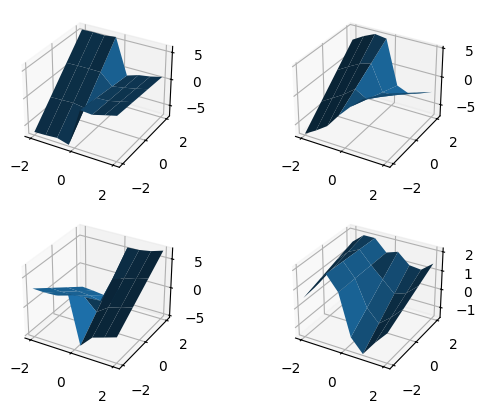

In [161]:
# now smooth out the transition some, so no longer discontinuous
def absval_smooth_decoupled3(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    indicator =  smooth_unit_step2(x * xp, alpha=5.0)
    smoothing_term = 1.0 * (1.0 - indicator) # hopefully will smooth out transition between xx' and yy' to constant
    return 0.3 + (x * xp + 2.0 * y * yp) * indicator + smoothing_term

cov = plot_2d_kernel(absval_smooth_decoupled3, nsamples=4, nx=8, ny=4, 
               sigma_n=1e-4, plot_cov=False) 

# check eigenvalues
# eigval, _ = np.linalg.eig(cov)
# print(f"{eigval=}")

/tmp/ipykernel_245853/3052958101.py:45: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, nsamples)


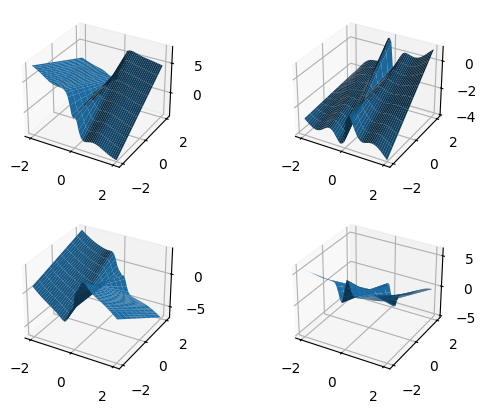

In [166]:
# was still not SPD (sym positive definite covariance), try adding windowed SE kernel term
# to damp out the other kernel effects?

# otherwise maybe look at neural net kernel, or some type of SVM kernels?
# think of some way to recover the piecewise behavior maybe..

# now smooth out the transition some, so no longer discontinuous
def absval_smooth_decoupled_plus_SE(_x, _xp):
    x = _x[0]; y = _x[1]
    xp = _xp[0]; yp = _xp[1]
    indicator =  smooth_unit_step2(x * xp, alpha=5.0)
    smoothing_term = (1.0 - indicator) # hopefully will smooth out transition between xx' and yy' to constant
    Lx = 1.0; Ly = 0.3
    SE_term = np.exp(-0.5 * (x - xp)**2 / Lx**2 - 0.5 * (y - yp)**2 / Ly**2)
    # window factor in the x \in [-1, 1] range
    window_factor = smooth_relu(1 - smooth_abs(x)) * smooth_relu(1 - smooth_abs(xp))
    return 0.3 + (x * xp + 2.0 * y * yp) * indicator + 0.0 * smoothing_term + 1.0 * SE_term * window_factor

cov = plot_2d_kernel(absval_smooth_decoupled3, nsamples=4, nx=50, ny=10, 
               sigma_n=1e-4, plot_cov=False) 

In [167]:
# TODO : try to fit the axial closed-form solution here with missing gamma data points..